#  Breast Cancer Diagnosis via Logistic Regression

---



In this demo, we will see how to visualize training data for classification and perform logistic regression.  As an example, we will use a widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)

and the original paper studying it can be found at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC55130/.

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from a fine needle aspiration (FNA) biopsy of breast tissue.  The features are scores from 1-10 descring certain aspects of the appearance of cells in the biopsy under microscope. The goal is to detect if the cells are benign or malignant.

## Loading and Visualizing the Data

We first load the packages as usual.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

Next, we load the data.  It is important to remove the missing values with `dropna`.

In [ ]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2.0,1,1,1,2
695,841769,2,1,1,1,2,1.0,1,1,1,2
696,888820,5,10,10,3,7,3.0,8,10,2,4
697,897471,4,8,6,4,3,4.0,10,6,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

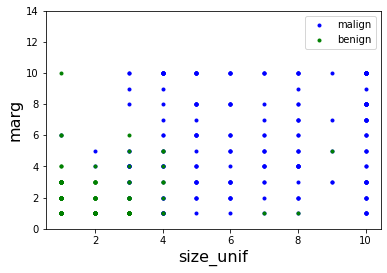

In [ ]:
# Get the response.  Convert to a zero-one indicator
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int) # now y has values of 0,1
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg']
X = df[xnames].values

# Create the scatter plot
plt.plot(X[Imal,0],X[Imal,1],'b.')
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

One way to improve the plot is add "jitter" to the data. Just for visualization, we will add random noise to all of our X values, which has the effect of seperating points on the plot. Play around with the `var` parameter below to see how it changes things.

We will re-use this code, so we define a function.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

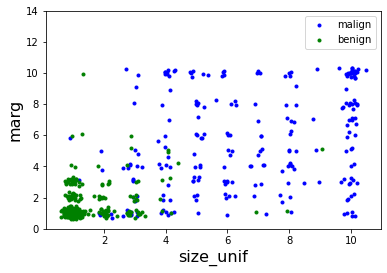

In [ ]:
def plot_cnt(X,y):

    # add random "jitter" to seperate points
    var = .15;
    Xj = X + var*np.random.randn(X.shape[0],X.shape[1])

    # Create the scatter plot
    plt.plot(Xj[Imal,0],Xj[Imal,1],'b.')
    plt.plot(Xj[Iben,0],Xj[Iben,1],'g.')
    plt.xlabel(xnames[0], fontsize=16)
    plt.ylabel(xnames[1], fontsize=16)
    plt.ylim(0,14)
    plt.legend(['malign','benign'],loc='upper right')
    return plt

plot_cnt(X,y)

## Some Simple Classification ideas

We can see that the benign samples are located in the lower left.  So, one simple classification rule is to define the region with a line.  We plot the region for one possible line with the following code.

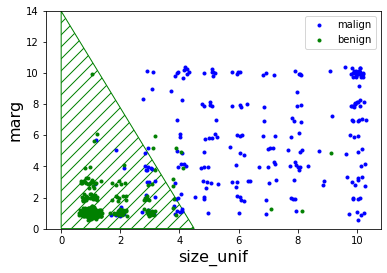

In [ ]:
from matplotlib import patches
plt = plot_cnt(X,y)

ax = plt.gca()
ax.add_patch(
    patches.Polygon([[0,0],[0,14],[4.5,0]],
        color='green',
        fill=False, hatch = '//'
    )
)

Here is an alternate classification rule based on two linear constraints.

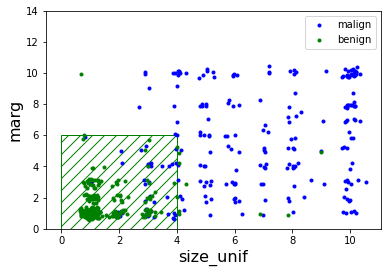

In [ ]:
plt = plot_cnt(X,y)
ax = plt.gca()
ax.add_patch(
    patches.Rectangle(
        (0, 0),   # (x,y)
        width=4, height=6,  color='green',
        fill=False, hatch = '//'
    )
)

Let us first try to find the best linear classifier by using least squares regression. I.e. we will simple minimize $\|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|_2^2$ where $y$ contains $0,1$ values.

In [ ]:
def fit_mult_linear(X,y):
    Xa = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    Xat = np.transpose(Xa);
    beta = np.linalg.inv(Xat@Xa)@Xat@y[:,None]
    return beta

In [ ]:
beta = fit_mult_linear(X,y)
print('beta=',str(beta[:,0]))

beta= [-0.08420067  0.10007944  0.04197521]


When classifiying using the learned linear function, a reasonable rule is to predict class `1` (malignant) for any example $\mathbf{x} \in \mathbb{R}^2$ where $\langle[1,\mathbf{x}],\boldsymbol{\beta}\rangle \geq 1/2$ and class  `0` (benign) for any example $i$ where $\langle[1,\mathbf{x}],\boldsymbol{\beta}\rangle < 1/2$. I.e. predict $1$ when the predication is closer to $1$ and than $0$.

We can visualize this classification rule by plotting all values of $x_1$ and $x_2$  where $\langle[1,\mathbf{x}],\boldsymbol{\beta}\rangle = 1/2$. I.e. solve for when $\beta_0 + \beta_1x_1 + \beta_2x_2 = 1/2$.

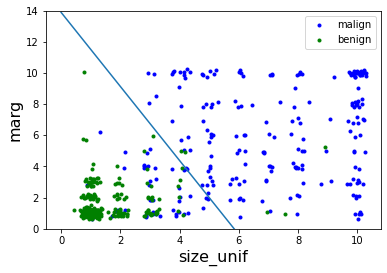

In [ ]:
plt = plot_cnt(X,y)
x1=np.zeros([11,1])
x2=np.zeros([11,1])
for i in range(11):
    x1[i]=i;
    x2[i]=(.5-beta[0]-beta[1]*i)/beta[2]

plt.plot(x1, x2)

Let's check out accuracy on the training data by seeing what percentage of labels we got correctly. We do a pretty descent job since we pretty naively applied a least squares regression method here.

In [ ]:
Xa = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
yhat = (Xa@beta)[:,0]
yhati= (yhat >=.5).astype(int)
acc = np.mean(yhati == y)
print("Accuracy on training data using two features = %f" % acc)

Accuracy on training data using two features = 0.922401


We also calculate the precision and recall. Here a "positive" example is a malignant biopsy, which is what we are hoping to detect. See https://en.wikipedia.org/wiki/Precision_and_recall for a refresher on precision and recall.

In [ ]:
recall = np.sum((yhati == 1)*(y == 1))/np.sum(y == 1)
precision = np.sum((yhati == 1)*(y == 1))/np.sum(yhati == 1)
print("Recall: " + str(recall))
print("Precision: " + str(precision))

Recall: 0.799163179916318
Precision: 0.9744897959183674


## Logistic Functions


Overall, a basic linear classifier trained with squared loss did not do a bad job! However, we might hope to do a bit better on recall and overall accuracy. As discussed in class, the classifier above seems to be shifted a bit too far "right" than what we might guess would be ideal.

An alternative approach is to train a linear classifier with logistic loss. In particular, for a data vector $\mathbf{x}$, we let $h_{\mathbf{\beta}}(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^T\mathbf{\beta}}}$ and we minimize the cross-entropy loss (aka the logistic loss):
$$
L(\mathbf{\beta}) = - \sum_{i=1}^n y_i \log(h_{\mathbf{\beta}}(\mathbf{x}_i)) + (1-y_i) \log(1-h_{\mathbf{\beta}}(\mathbf{x}_i))
$$

Since we don't have a closed form expression for the optimal $\mathbf{\beta}^*$ to minimized this loss, we need to find $\mathbf{\beta}^*$ using an iterative method like gradient descent. We will discuss the details of how to do this in a future lecture. For now we just use the built in logistic regression functionality within `sklearn`.

Note that by setting `penalty='none'` we are opting to use no regularization. We have to set the `solver` parameter manually to avoid an error with the default solver. LBFGS is just a specific iterative method for finding the optimal parameters for the model (for more info see https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Since our problem is small, the specific choice of solver doesn't matter too much.

In [ ]:
logreg = linear_model.LogisticRegression(penalty='none',solver='lbfgs')
logreg.fit(X, y)
betal = np.array([logreg.intercept_[0],logreg.coef_[0,0],logreg.coef_[0,1]])

Again we want to predict $y_i = 0$ whenever $h_{\boldsymbol{\beta}}(\mathbf{x}_i) < 1/2$ and $y_i = 1$ otherwise. With some quick algebra, it's not hard to check that this is equivalent to predicting $y_i = 0$ whenever $\mathbf{x}_i^T\boldsymbol{\beta} < 0$ and $y_i = 1$ whenever $\mathbf{x}_i^T\boldsymbol{\beta} \geq 0$. This is what we do below.

In [ ]:
yhat = (Xa@betal[:,None])[:,0]
yhatl= (yhat >=0).astype(int) # these are our predicted class labels.

Again we compute the overall accuracy, precision, and recall.

In [ ]:
acc = np.mean(yhatl == y)
print("Accuracy on training data using two features = %f" % acc)
recall = np.sum((yhatl == 1)*(y == 1))/np.sum(y == 1)
precision = np.sum((yhatl == 1)*(y == 1))/np.sum(yhatl == 1)
print("Recall: " + str(recall))
print("Precision: " + str(precision))

Accuracy on training data using two features = 0.941435
Recall: 0.895397489539749
Precision: 0.9344978165938864


We improved on both accuracy and recall! And a visual plot of our new linear classifier confirms a better visual fit to the data.

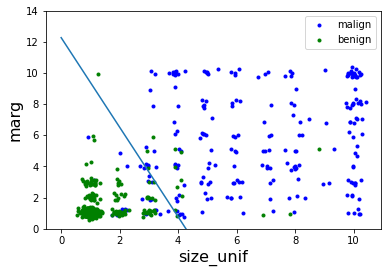

In [ ]:
plt = plot_cnt(X,y)
x1=np.zeros([11,1])
x2=np.zeros([11,1])
for i in range(11):
    x1[i]=i;
    x2[i]=(0-betal[0]-betal[1]*i)/betal[2]

plt.plot(x1, x2)

Finally, we try fitting a logistic regression model with all of the predictor data. Here we do everything with `sklearn`'s built in functions. Not surprisingly, we see a lift in performance.

In [ ]:
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
Xfull = np.array(df[xnames])
logreg = linear_model.LogisticRegression(penalty='l2',solver='lbfgs')
logreg.fit(Xfull, y)
yhatf = logreg.predict(Xfull)
acc = np.mean(yhatf == y)
print("Accuracy on training data using two features = %f" % acc)
recall = np.sum((yhatf == 1)*(y == 1))/np.sum(y == 1)
precision = np.sum((yhatf == 1)*(y == 1))/np.sum(yhatf == 1)
print("Recall: " + str(recall))
print("Precision: " + str(precision))

Accuracy on training data using two features = 0.969253
Recall: 0.9539748953974896
Precision: 0.957983193277311
